In [1]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from scipy import stats
from scipy.signal import detrend
import pandas as pd
import pickle

proj_dir = '/home/ubuntu/bigStick/antarctic_melting'
data_dir = os.path.join(proj_dir,'data','analysis')
raw_dir = os.path.join(data_dir,'raw')
int_dir = os.path.join(data_dir,'interim')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)
tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

%load_ext autoreload
%autoreload 2

from pySSA.mySSA import mySSA
from log_progress import log_progress
from rotate_vector_roms import rotate_vector_roms
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

# 1. Artificiall signal construction

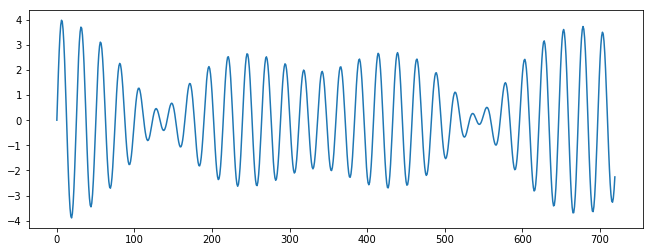

In [186]:
periods = [23.93, 25.82, 24.07, 26.87]
t = np.arange(0,30*24)
signal = np.zeros_like(t)
for p in periods:
    signal = signal + np.sin(2*np.pi/p*t)
plt.plot(t,signal)
plt.show()
tsPure = pd.Series(signal, index=pd.date_range("2007",freq='H',periods=np.size(signal)))

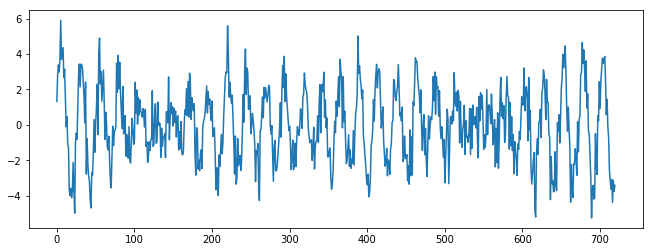

In [187]:
noise = np.random.normal(0,1,np.size(t))
signal = signal + noise
plt.plot(t,signal)
plt.show()

# 2. Decomposition with SSA and goodness of fit

In [188]:
ts = pd.Series(signal, index=pd.date_range("2007",freq='H',periods=np.size(signal)))
ssa = mySSA(ts)

In [189]:
[x for x in dir(ssa) if '__' not in x and x[0]!='_']

['decompose',
 'diagonal_averaging',
 'embed',
 'forecast_recurrent',
 'freq',
 'get_contributions',
 'ts',
 'ts_N',
 'ts_name',
 'ts_v',
 'view_reconstruction',
 'view_s_contributions',
 'view_time_series']

In [209]:
ssa.embed(embedding_dimension=50, verbose=True)
ssa.decompose(verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  50
Trajectory dimensions	: (50, 671)
Complete dimension	: (50, 671)
Missing dimension     	: (50, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 50
Dimension of projection space	: 50
Characteristic of projection	: 1.0


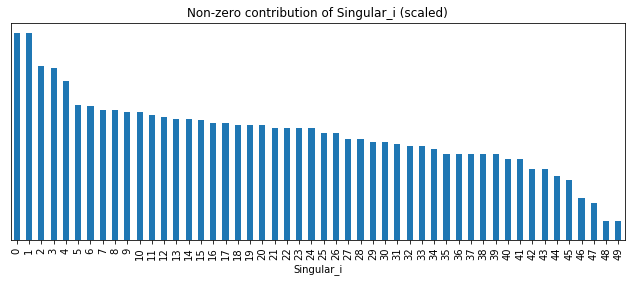

In [210]:
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions(adjust_scale=True)

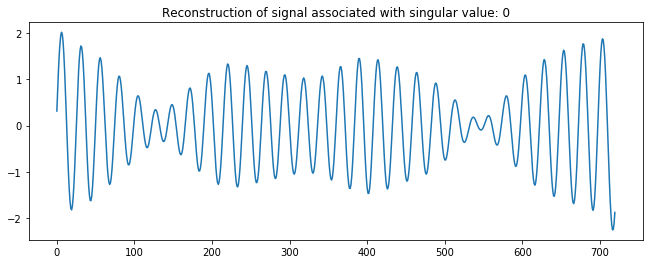

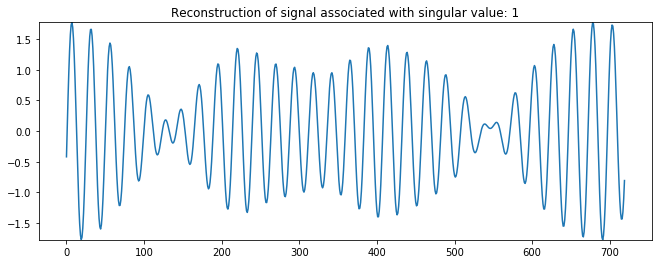

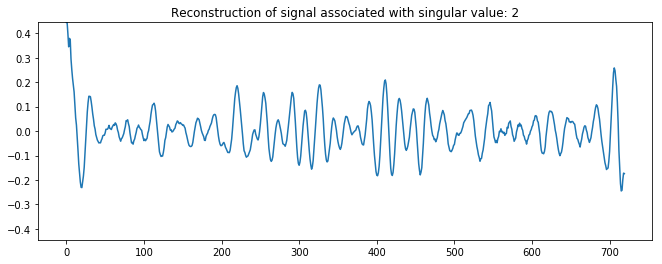

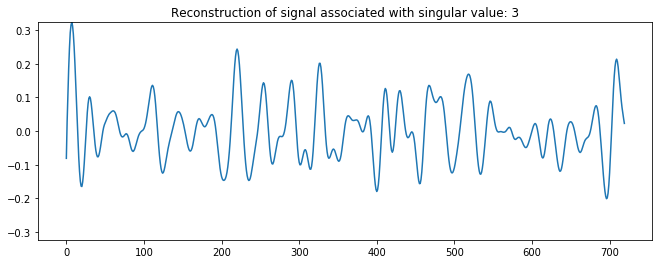

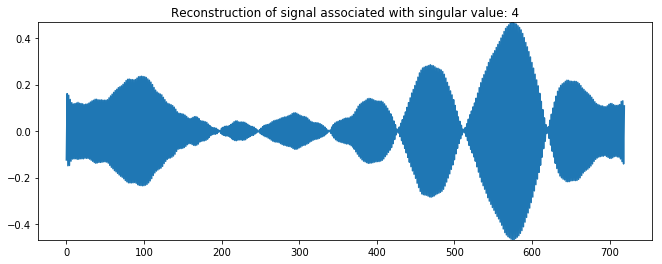

In [211]:
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


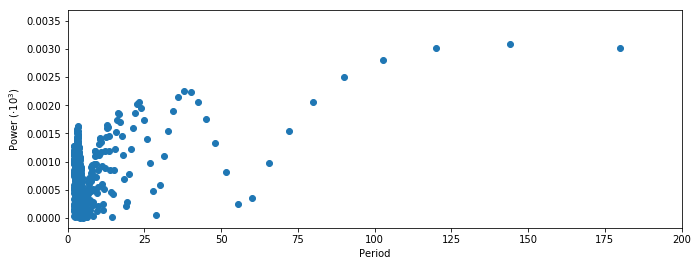

In [208]:
from scipy import fftpack
recon = ssa.view_reconstruction(ssa.Xs[0], return_df=True, plot=False)
ft = fftpack.fft(recon)
frequencies = fftpack.fftfreq(recon.shape[0], 1)
periods = 1 / frequencies

plt.figure()
plt.plot(periods, abs(ft) * 1e-3, 'o')
plt.xlim(0, 200)
plt.xlabel('Period')
plt.ylabel('Power ($\cdot10^3$)')

plt.show()

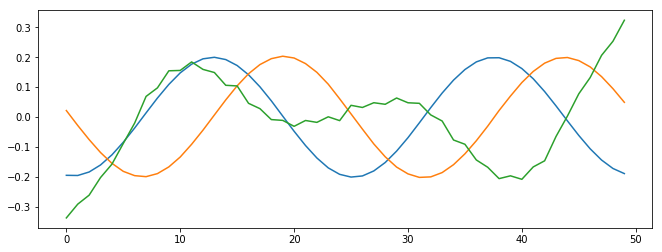

In [212]:
rho = np.array(ssa.U[:,0:10]).transpose()

plt.plot(ssa.U[:,0:3])


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


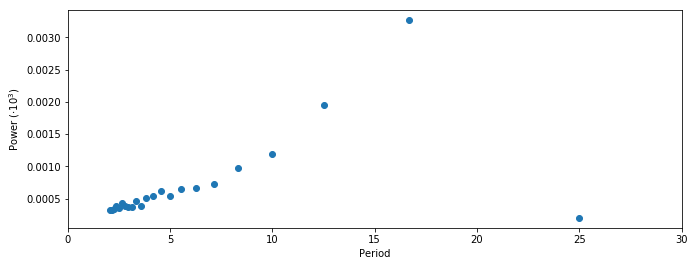

16.666666666666668

In [215]:
from scipy import fftpack
#recon = ssa.view_reconstruction(ssa.U[:,0:6], return_df=True, plot=False)
rho_sel = rho[2]
ft = fftpack.fft(rho_sel)
frequencies = fftpack.fftfreq(rho_sel.shape[0], 1)
periods = 1 / frequencies

plt.figure()
plt.plot(periods, abs(ft) * 1e-3, 'o')
plt.xlim(0, 30)
plt.xlabel('Period')
plt.ylabel('Power ($\cdot10^3$)')
plt.show()
periods[abs(ft).argmax()]

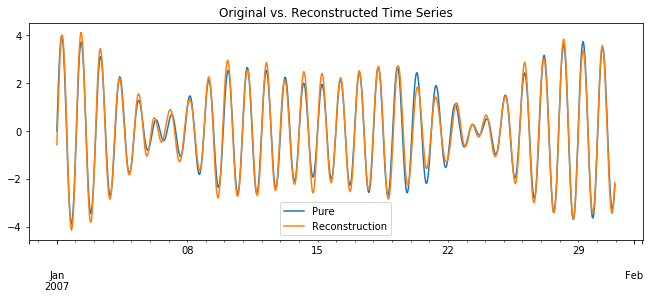

In [11]:
streams = [i for i in range(2)]
reconstructed = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], 
                                          names=streams, return_df=True, plot=False)
ts_copy2 = ssa.ts.copy()
ts_copy2['Reconstruction'] = reconstructed.Reconstruction.values
ts_copy2['Pure'] = tsPure.values
ts_copy2.plot(y=['Pure','Reconstruction'],title='Original vs. Reconstructed Time Series')

# real signal

In [255]:
file_path = os.path.join(raw_dir,'scratch','waom4_hr','ocean_avg_0010.nc')
tides = xr.open_dataset(file_path,chunks={'xi_rho':75,'eta_rho':75})
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

signal = tides.ubar[:,800,500]
signal = signal - signal.mean('ocean_time')
#signal = detrend(signal)

ts = pd.Series(signal, index=pd.date_range("2007",freq='H',periods=np.size(signal)))
ssa = mySSA(ts)

Original signal:

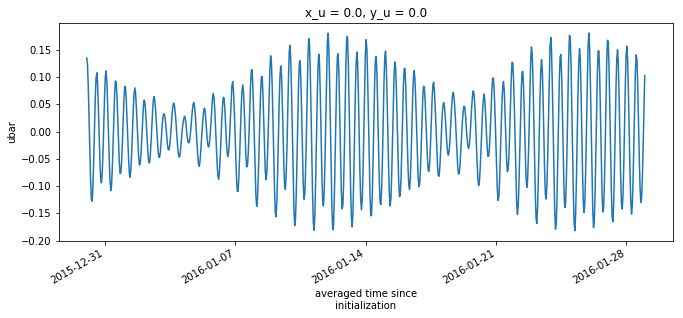

In [265]:
signal.plot()

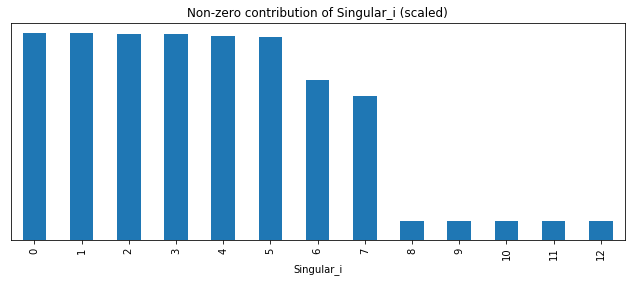

In [270]:
ssa.embed(embedding_dimension=50, verbose=False)
ssa.decompose(verbose=False)
%matplotlib inline 
rcParams['figure.figsize'] = 11, 4
ssa.view_s_contributions(adjust_scale=True)

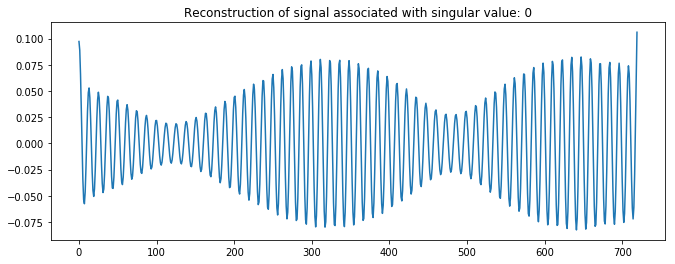

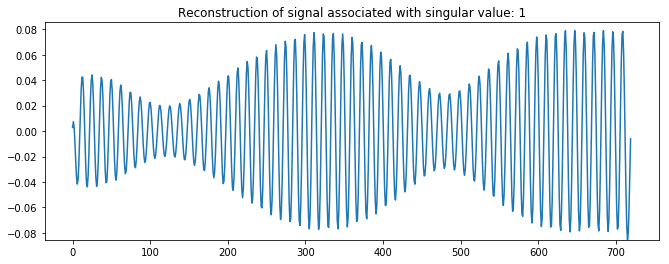

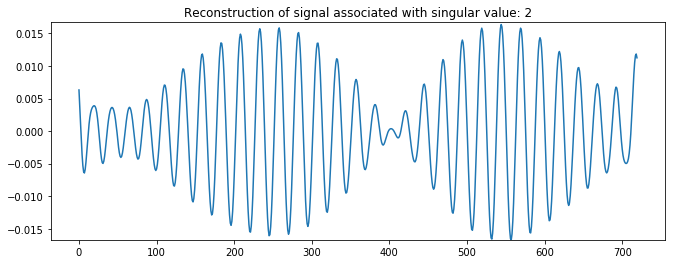

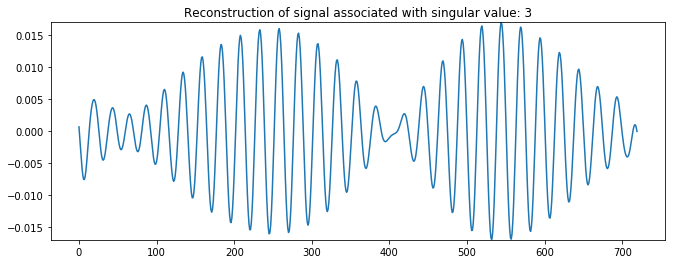

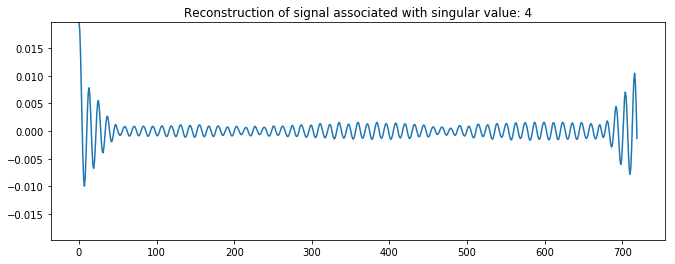

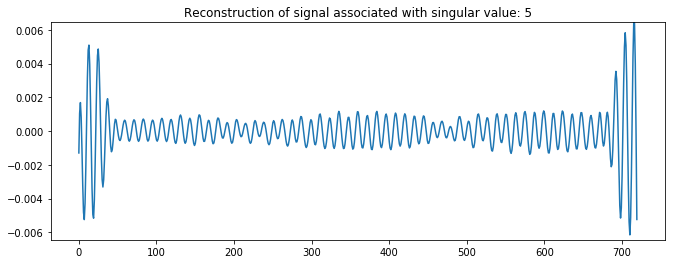

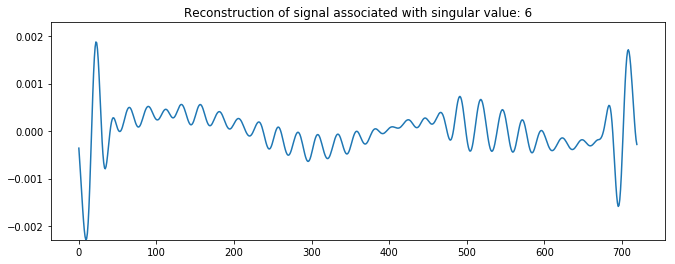

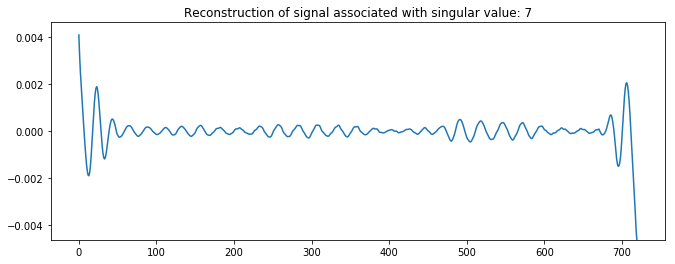

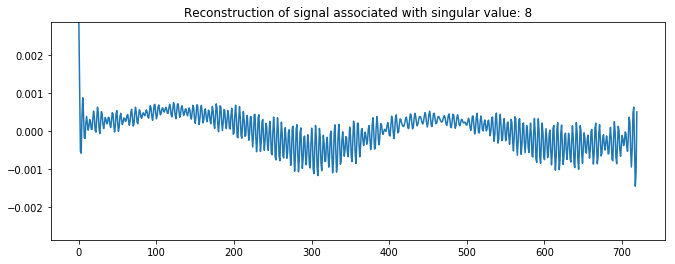

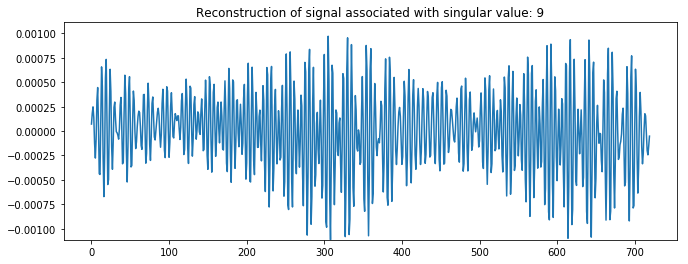

In [271]:
for i in range(10):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

In [272]:
rho = np.array(ssa.U[:,0:10]).transpose()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


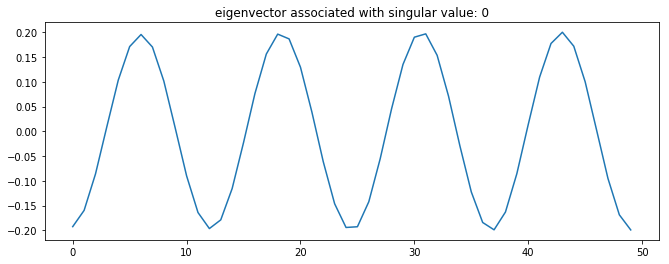

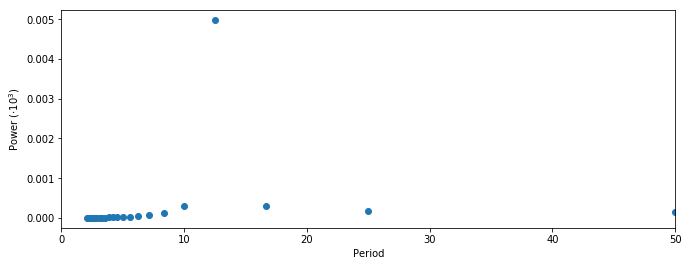

max period: 12.5


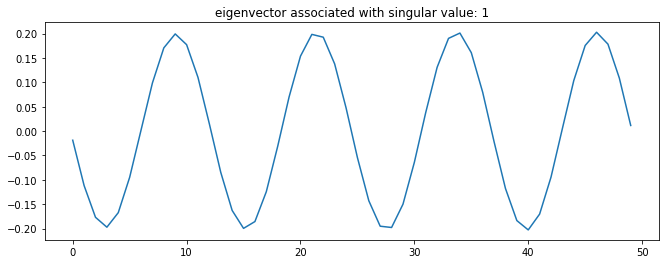

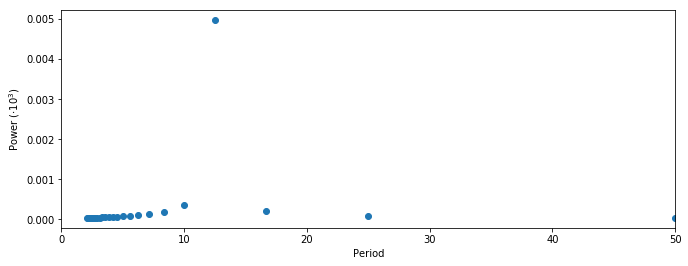

max period: 12.5


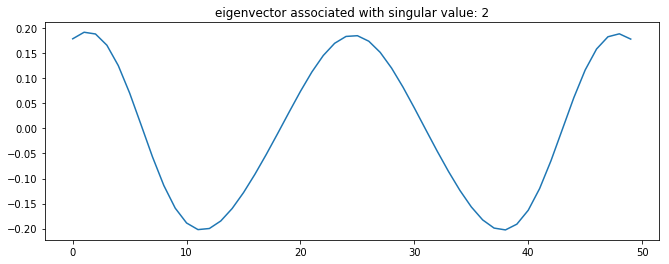

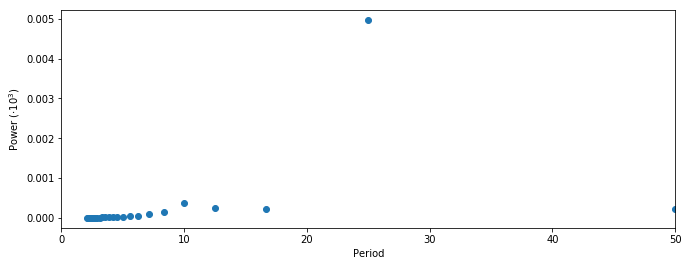

max period: 25.0


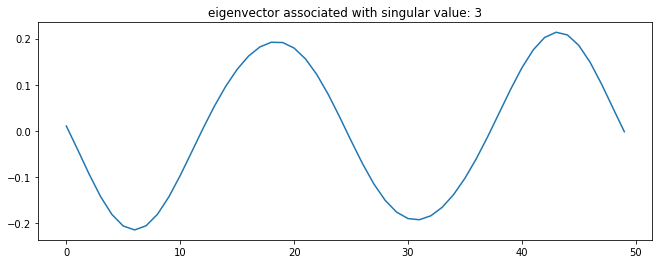

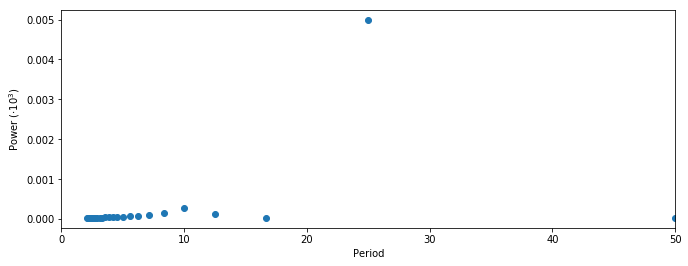

max period: 25.0


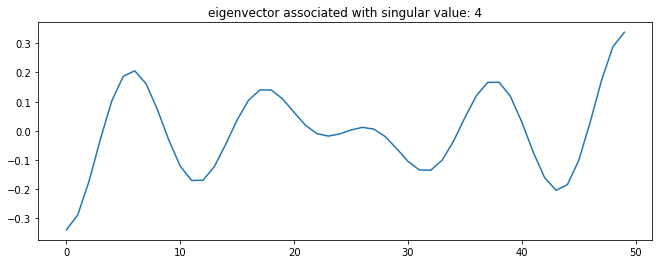

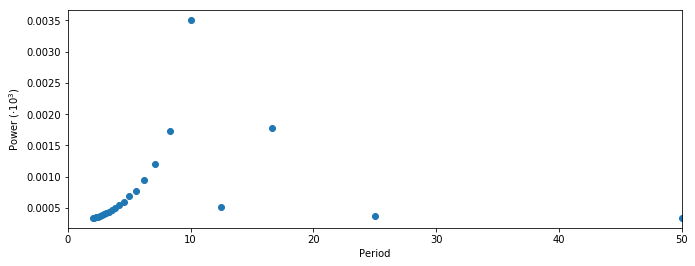

max period: 10.0


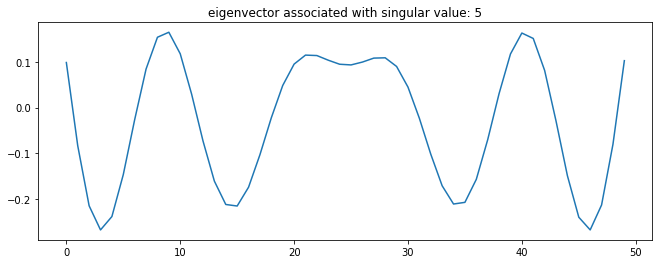

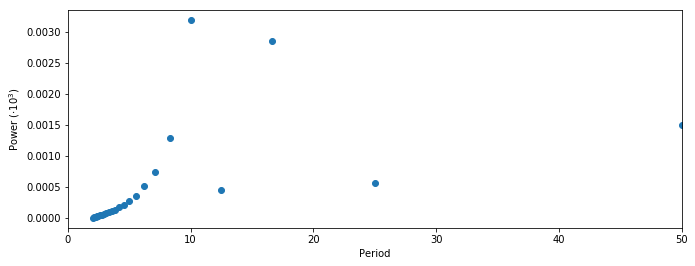

max period: 10.0


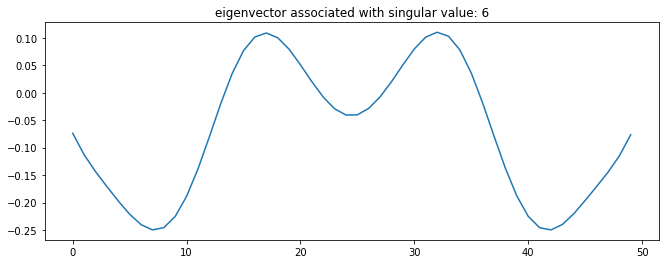

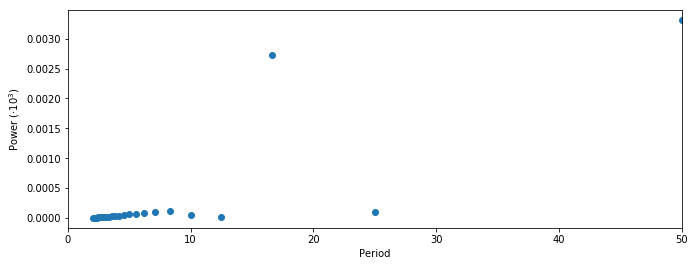

max period: inf


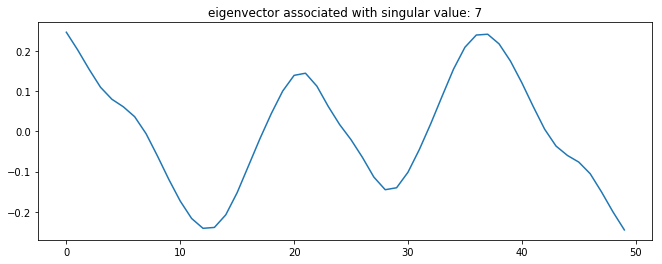

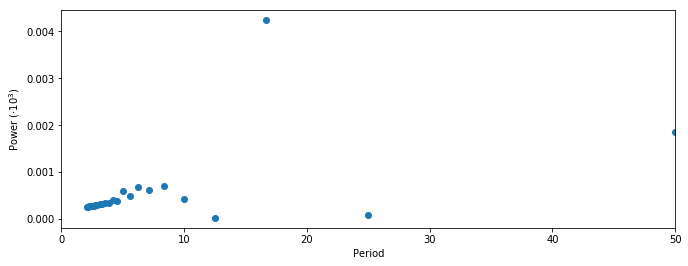

max period: 16.666666666666668


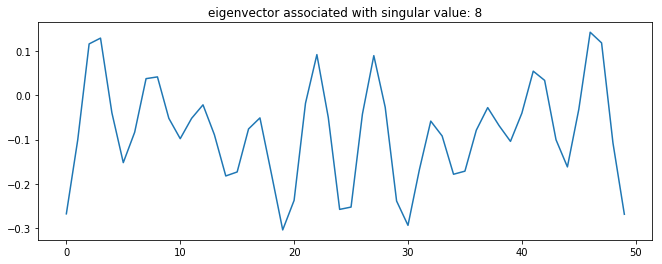

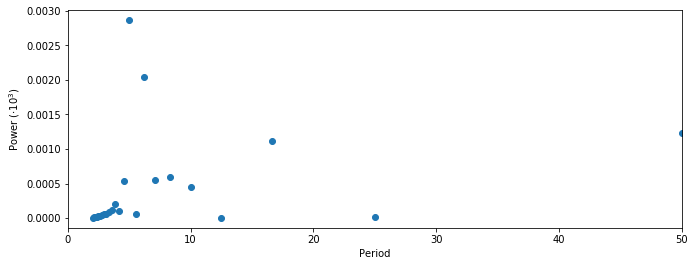

max period: inf


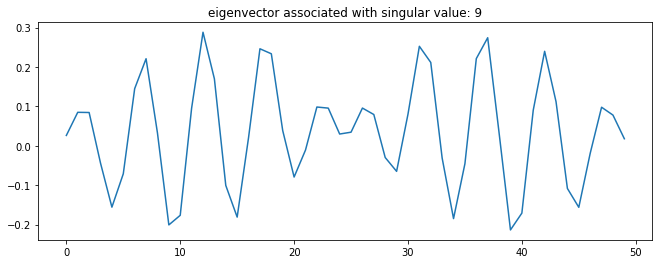

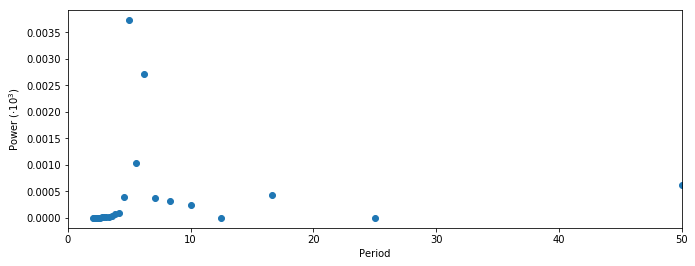

max period: 5.0


In [273]:
from scipy import fftpack
#recon = ssa.view_reconstruction(ssa.U[:,0:6], return_df=True, plot=False)
for i in range(10):
    rho_sel=rho[i]
    plt.plot(rho_sel)
    plt.title(f'eigenvector associated with singular value: {i}')
    ft = fftpack.fft(rho_sel)
    frequencies = fftpack.fftfreq(rho_sel.shape[0], 1)
    periods = 1 / frequencies

    plt.figure()
    plt.plot(periods, abs(ft) * 1e-3, 'o')
    plt.xlim(0, 50)
    plt.xlabel('Period')
    plt.ylabel('Power ($\cdot10^3$)')
    plt.show()
    print(f'max period: {periods[abs(ft).argmax()]}')

# 3. Testing different window sizes (artifical and "real" signal)

In [49]:
def ssa_window(K):
    ssa.embed(embedding_dimension=K)
    ssa.decompose()
    streams = [i for i in range(2)]
    reconstructed = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], 
                                              names=streams, return_df=True, plot=False)
    ts_copy2 = ssa.ts.copy()
    ts_copy2['Reconstruction'] = reconstructed.Reconstruction.values
    ts_copy2['Pure'] = tsPure.values
    #ts_copy2.plot(y=['Pure','Reconstruction'],title='Original vs. Reconstructed Time Series')
    #print(np.sum(ts_copy2['Reconstruction']**2 - ts_copy2['Pure']**2)/ts_copy2['Reconstruction'].size)
    #plt.show()
    return np.sum((ts_copy2['Reconstruction'] - ts_copy2['Pure'])**2)/ts_copy2['Reconstruction'].size

In [13]:
rmses = []
ws = np.arange(3,50,2)
for i in log_progress(ws):
    rmses.append(ssa_window(i))

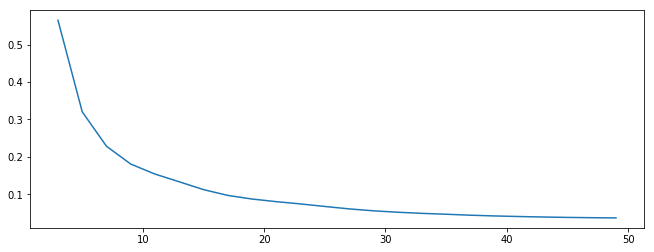

In [14]:
plt.plot(ws,rmses)

In [64]:
file_path = os.path.join(raw_dir,'waom4_hr','ocean_avg_0010.nc')
tides = xr.open_dataset(file_path,chunks={'xi_rho':75,'eta_rho':75})
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

ts = tides.ubar[:,800,500]
demeaned = ts.values - ts.values.mean()
ts = pd.Series(demeaned, index=pd.date_range("2007",freq='H',periods=np.size(demeaned)))
ssa = mySSA(ts)
ssa.embed(embedding_dimension=28, verbose=True)
ssa.decompose(verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  28
Trajectory dimensions	: (28, 693)
Complete dimension	: (28, 693)
Missing dimension     	: (28, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 28
Dimension of projection space	: 11
Characteristic of projection	: 0.9998


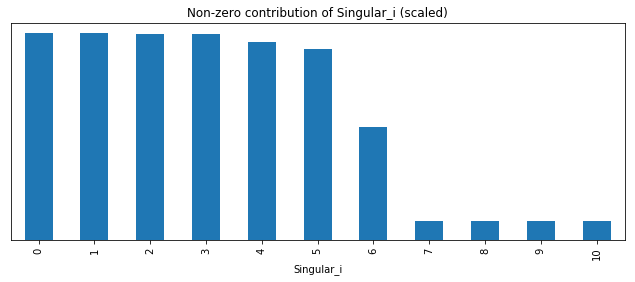

In [65]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions(adjust_scale=True)

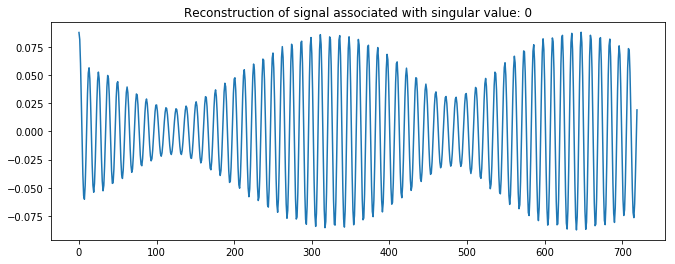

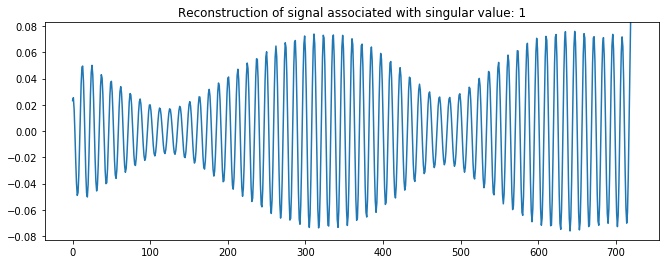

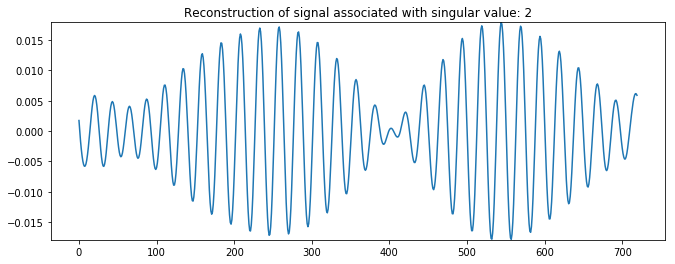

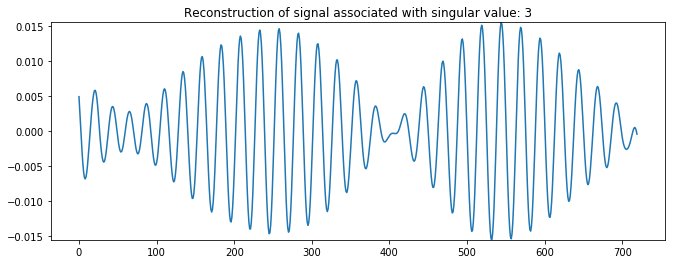

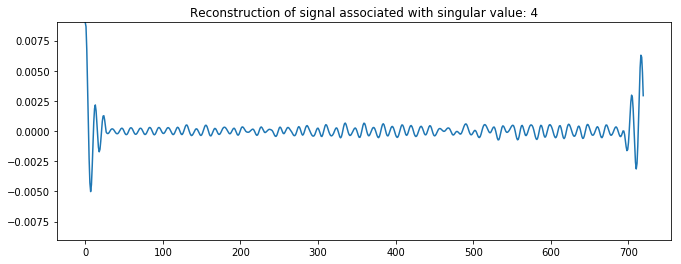

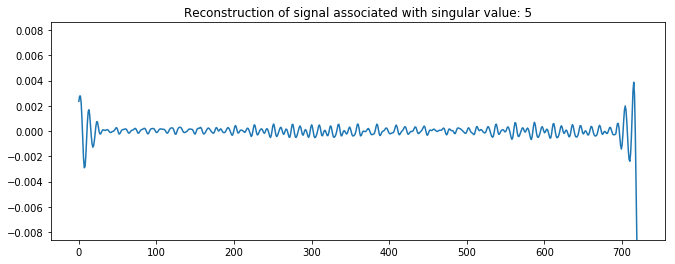

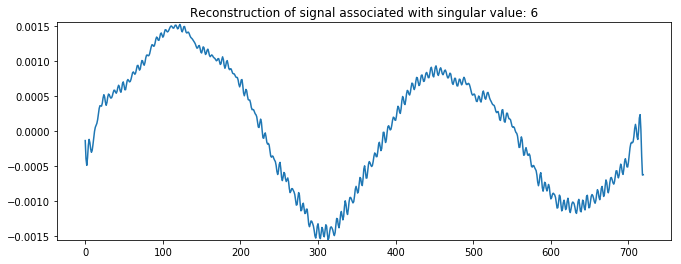

In [38]:
for i in range(7):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

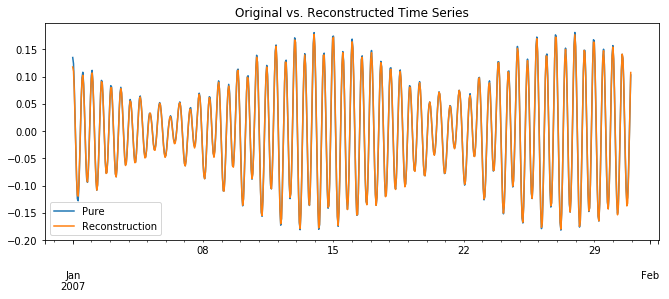

In [47]:
streams = [i for i in range(4)]
reconstructed = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], 
                                          names=streams, return_df=True, plot=False)
ts_copy2 = ssa.ts.copy()
ts_copy2['Reconstruction'] = reconstructed.Reconstruction.values
ts_copy2['Pure'] = demeaned
ts_copy2.plot(y=['Pure','Reconstruction'],title='Original vs. Reconstructed Time Series')

In [56]:
def ssa_window(K):
    ssa.embed(embedding_dimension=K)
    ssa.decompose()
    streams = [i for i in range(4)]
    reconstructed = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], 
                                              names=streams, return_df=True, plot=False)
    ts_copy2 = ssa.ts.copy()
    ts_copy2['Reconstruction'] = reconstructed.Reconstruction.values
    ts_copy2['Pure'] = demeaned
    #ts_copy2.plot(y=['Pure','Reconstruction'],title='Original vs. Reconstructed Time Series')
    #print(np.sum(ts_copy2['Reconstruction']**2 - ts_copy2['Pure']**2)/ts_copy2['Reconstruction'].size)
    #plt.show()
    return np.sqrt(np.mean((ts_copy2['Reconstruction'] - ts_copy2['Pure'])**2))

rmses = []
ws = np.arange(4,50,2)
for i in log_progress(ws):
    rmses.append(ssa_window(i))

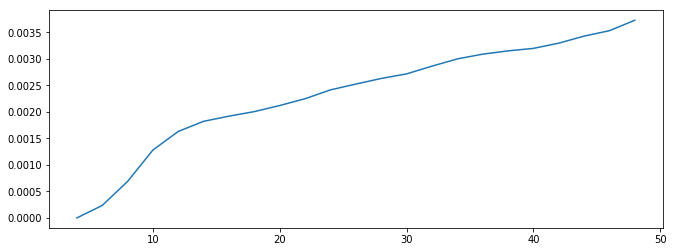

In [57]:
plt.plot(ws,rmses)

# 4. Single grid cell |u|_tide_cyclic (function)

In [5]:
file_path = os.path.join(raw_dir,'waom4_hr','ocean_avg_0010.nc')
tides = xr.open_dataset(file_path,chunks={'xi_rho':75,'eta_rho':75})
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][1050:1140,95:113] = True
mask_shelf['Total Antarctica'][:,1500:] = False

grd.mask_rho[570:610,1030:1140] = False

In [48]:
def get_uv_rho(u,v,mask):
    u_rho = np.zeros((u.ocean_time.size,mask.eta_rho.size,mask.xi_rho.size))
    v_rho = np.zeros_like(u_rho)
    for i in log_progress(range(u.ocean_time.size)):
        u_rho[i],v_rho[i] = rotate_vector_roms(u[i,:,:].values,v[i,:,:].values,np.zeros_like(mask))
    return u_rho,v_rho

def get_ssa(ts):
    demeaned = ts - ts.mean()
    ts = pd.Series(demeaned, index=pd.date_range("2007",freq='H',periods=np.size(demeaned)))
    ssa = mySSA(ts)
    ssa.embed(embedding_dimension=28)
    ssa.decompose()
    streams = [i for i in range(4)]
    return ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], names=streams, return_df=True, plot=False)

def get_u_tide(u_rho,v_rho):
    u_tide = get_ssa(u_rho)
    v_tide = get_ssa(v_rho)
    uv_tide = np.sqrt(np.mean(u_tide**2+v_tide**2))
    return uv_tide

# 5. map |u|_tide_cyclic (function)

In [78]:
def get_u_tide_map(u_rho,v_rho,mask):
    out = np.empty_like(u_rho[0])
    out[:]=np.nan
    
    for j in log_progress(range(np.size(out,0)),name='eta'):
        if mask[j,:].any()==True:        
            for i in range(np.size(out,1)):           
                if (mask[j,i]==True):
                    if (np.isnan(u_rho[:,j,i]).any()==False):
                        out[j,i] = get_u_tide(u_rho[:,j,i],v_rho[:,j,i]).values
                        
                    
    return xr.DataArray(out,dims=('eta_rho','xi_rho')).where(mask)

In [83]:
sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,1100),
           'xi_u' : slice(350,649),'eta_u' : slice(700,1100),
           'xi_v' : slice(350,650),'eta_v' : slice(700,1099)}
FRIS = tides.isel(sel)
rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,1100)}
FRIS_mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)

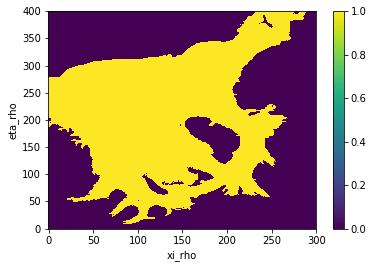

In [84]:
FRIS_mask.plot()

In [ ]:
u_rho,v_rho = get_uv_rho(FRIS.ubar,FRIS.vbar,FRIS_mask)
u_tide = get_u_tide_map(u_rho,v_rho,FRIS_mask)
u_tide.to_netcdf(os.path.join(int_dir,'u_tide_ssa.nc'))

In [ ]:
u_tide.plot()